# What about Data?
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test the network on the test data

In [1]:
import torch
import torchvision
import torchvision.transforms as T

In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

CLASSES = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


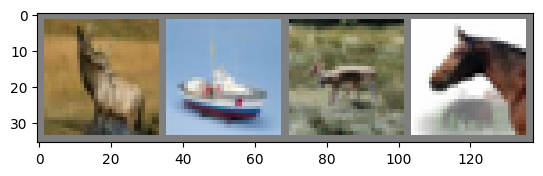

deer  ship  deer  horse


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f"{CLASSES[labels[j]]:5s}" for j in range(batch_size)))

In [7]:
# Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 6 x 28 x 28
        self.pool = nn.MaxPool2d(2, 2)
        # 6 x 14 x 14
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 16 x 10 x 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(len(CLASSES))

In [8]:
# Define Loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
# Train the net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d} loss: {running_loss / 2000:.3f}]")
            running_loss = 0.0

print("Finished Training")

[1,  2000 loss: 2.184]
[1,  4000 loss: 1.879]
[1,  6000 loss: 1.689]
[1,  8000 loss: 1.601]
[1, 10000 loss: 1.551]
[1, 12000 loss: 1.484]
[2,  2000 loss: 1.412]
[2,  4000 loss: 1.382]
[2,  6000 loss: 1.367]
[2,  8000 loss: 1.366]
[2, 10000 loss: 1.316]
[2, 12000 loss: 1.287]
Finished Training


In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

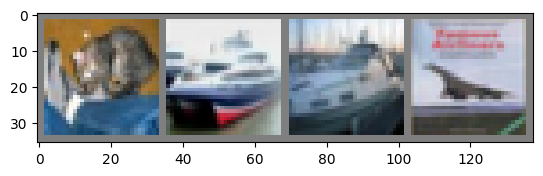

GroundTruth:  cat   ship  ship  plane


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(4)))

In [16]:
net = Net(len(CLASSES))
net.load_state_dict(torch.load(PATH))
net = net.to(device)

images = images.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f"{CLASSES[predicted[j]]:5s}" for j in range(batch_size)))

Predicted:  cat   ship  ship  plane


In [18]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total} %")

Accuracy of the network on the 10000 test images: 54.59 %


In [19]:
# prepare to count predictions for each class

correct_pred = {classname: 0 for classname in CLASSES}
total_pred = {classname: 0 for classname in CLASSES}

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[CLASSES[label]] += 1
            total_pred[CLASSES[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: plane is 63.0 %
Accuracy for class: car   is 51.8 %
Accuracy for class: bird  is 34.0 %
Accuracy for class: cat   is 41.0 %
Accuracy for class: deer  is 33.2 %
Accuracy for class: dog   is 54.1 %
Accuracy for class: frog  is 64.4 %
Accuracy for class: horse is 64.8 %
Accuracy for class: ship  is 74.3 %
Accuracy for class: truck is 65.3 %


In [20]:
del dataiter